# <font color='#FF5555'>**Est-ce un chat, ou un chien ?**</font>

Ce NoteBook est un exercice qui donne suite au travail effectué prédédemment.  
Le but ici est de modifier notre modèle, pour qu'il soit capable d'entraîner un neuronne dans le but de déterminer si une image donnée est une image de chien, ou de chat.

## A. L'existant

Commençons par reprendre le travail existant

In [14]:
#!pip install numpy
#!pip install matplotlib
#!pip install wheel
#!pip install scikit-learn

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

In [15]:
X, y  = make_blobs(n_samples=100, n_features=2, centers=2, random_state=0)
y = y.reshape((y.shape[0], 1))

def initialisation(X):
    W = np.random.randn(X.shape[1], 1)
    b = np.random.randn(1)
    return (W, b)

def model(X, W, b):
    Z = X.dot(W) + b
    A = 1 / (1 + np.exp(-Z))
    return A

def log_loss(A, y):
    return 1 / len(y) * np.sum( -y * np.log(A) - (1 - y) * np.log(1 - A))

def gradients(A, X, y):
    dW = 1 / len(y) * np.dot(X.T, A - y)
    db = 1 / len(y) * np.sum(A - y)
    return (dW,db)

def update(dW, db, W, b, learning_rate):
    W = W - learning_rate * dW
    b = b - learning_rate * db
    return (W, b)

def predict(X, W, b):
    A = model(X, W, b)
    return A >= 0.5

def artificial_neuron(X, y, learning_rate = 0.1, n_iter = 100):
    # initialisation W, b
    W, b = initialisation(X)
    
    Loss = []
    
    for i in range(n_iter):
        A = model(X, W, b)
        Loss.append(log_loss(A, y))
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
    
    y_pred = predict(X, W, b)
    print('taux de réussite : ',accuracy_score(y, y_pred))
    
    plt.plot(Loss)
    plt.show()
    
    return (W, b)

## B. Le train set et le test set

Je récupère un train set et un test set permettant d'entraîner mon intelligence artificielle et de la tester.  
Je récupère aussi un bout de code permettant d'ouvrir et fermer des fichiers au format h5py.

In [16]:
#en cas d'erreur, décommenter et exécuter
#!pip install h5py

In [17]:
from utilities import *
X_train, y_train, X_test, y_test = load_data()

Je charge mes données et essaie d'analyser ce que je viens de récupérer.

In [18]:
print(X_train.shape)
print(y_train.shape)
print(np.unique(y_train, return_counts=True))

(1000, 64, 64)
(1000, 1)
(array([0., 1.]), array([500, 500], dtype=int64))


On voit que dans le train set, on a 1000 photos de 64x64 pixels et 1000 étiquettes. Chaque étiquette à une valeur (0 pour chat, 1 pour chien). Il y en a 500 de chaque

In [19]:
print(X_test.shape)
print(y_test.shape)
print(np.unique(y_test, return_counts=True))

(200, 64, 64)
(200, 1)
(array([0., 1.]), array([100, 100], dtype=int64))


Même chose ici avec le test set, composé de 200 photos.

Affichons les 10 premières photos de notre train set

C:\Users\Remey\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


<function matplotlib.pyplot.show(close=None, block=None)>

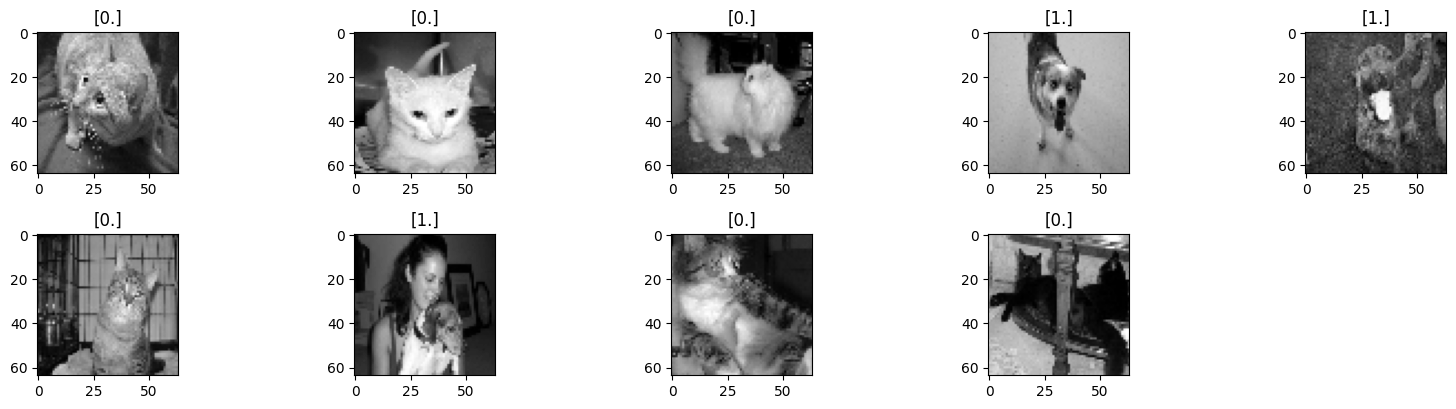

In [20]:
plt.figure(figsize=(16, 8))
for i in range(1, 10):
    plt.subplot(4, 5, i)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(y_train[i])
    plt.tight_layout()
plt.show

## C. Applatir les images ?

Dans un premier temps, nous allons devoir rendre les données des images "plates".  
En effet, nous allons avoir besoin de ces données sours forme d'un tableau à 1 dimension et non de 2.  
Nous allons donc "applatir" nos images.


In [21]:
def flatten_image(imageArray):
    newWidth = imageArray.shape[1] * imageArray.shape[2]
    return np.reshape(imageArray, (imageArray.shape[0], newWidth) )

In [22]:
X_train_reshape = flatten_image(X_train)
X_test_reshape = flatten_image(X_test)
X_train_reshape.shape

(1000, 4096)

Nos données sont à présent sous la même forme que lors du dernier exercice. Nous pouvons donc tester et voir si notre IA apprend d'elle-même.

C:\Users\Remey\AppData\Local\Temp\ipykernel_11340\827659643.py:11: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))
C:\Users\Remey\AppData\Local\Temp\ipykernel_11340\827659643.py:15: RuntimeWarning: divide by zero encountered in log
  return 1 / len(y) * np.sum( -y * np.log(A) - (1 - y) * np.log(1 - A))
C:\Users\Remey\AppData\Local\Temp\ipykernel_11340\827659643.py:15: RuntimeWarning: invalid value encountered in multiply
  return 1 / len(y) * np.sum( -y * np.log(A) - (1 - y) * np.log(1 - A))


taux de réussite :  0.509


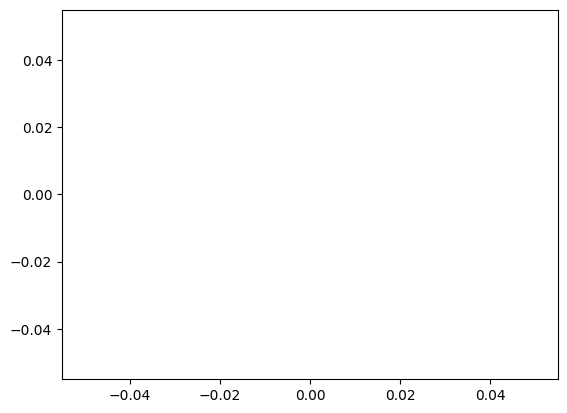

In [23]:
W, b = artificial_neuron(X_train_reshape, y_train)

On remarque qu'il n'y a aucun résultat : il y a une erreur.  
Nous utilisons la fonction exponentielle avec de trop grand nombres : cela rend les calculs impossibles.  
Les valeurs de retour font que le reste de nos calculs devient absurde (comme un logarithme de 0)

## D. Résolution de l'erreur de logarithme

Le problème vient en effet de la logarithme utilisée dans la fonction LogLoss.  
L'astuce pour éviter le 0 est d'additionner la potentielle valeur nulle avec une valeur epsilon, extrêmement petite.

In [24]:
def log_loss(A, y):
    epsilon = 1e-15
    return 1 / len(y) * np.sum( -y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon))

Cela affectera légèrement le calcul coût, mais pas le calcul des gradients ou de la mise à jour. Réessayons à présent de réentraîner notre modèle

C:\Users\Remey\AppData\Local\Temp\ipykernel_11340\827659643.py:11: RuntimeWarning: overflow encountered in exp
  A = 1 / (1 + np.exp(-Z))


taux de réussite :  0.512


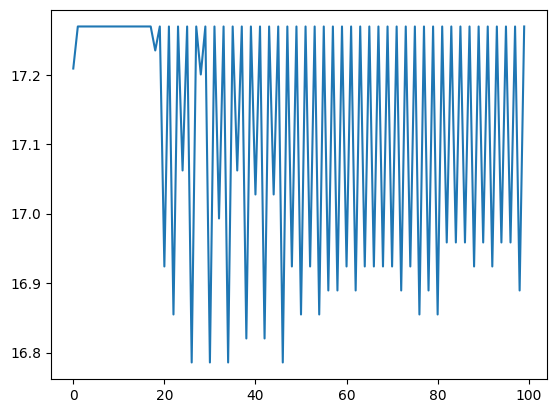

In [25]:
W, b = artificial_neuron(X_train_reshape, y_train)

L'aprentissage est chaotique...  
De plus, nous avons toujours une erreur "d'overflow" : nos valeurs passées à la fonction exponentielle sont trop grandes.

## E. Compréhension de l'erreur *d'overflow*

Nous allons devoir normaliser nos données.  
Lorsque l'on fait du machine learning ou du deep learning, et que l'on utilise une descente de gradient, cette étape est obligatoire.  
Ici, la différence d'échelle entre les variables w1 et w2 "compriment" la fonction coût, rendant le travail pour l'ia quasiment impossible.

Faisons une petite démonstration pour illustrer le problème.  
Nous allons tracer ici l'évolution de la fonction coût en fonction de W1 et W2.

In [26]:
lim = 10
h = 100
W1 = np.linspace(-lim, lim, h)
W2 = np.linspace(-lim, lim, h)

W11, W22 = np.meshgrid(W1, W2)

W_final = np.c_[W11.ravel(), W22.ravel()].T
#Il nous faut des dimensions de W = (2,10000) -> 2 variables et 100x100 configurations possibles
W_final.shape

(2, 10000)

In [27]:
b = 0
Z = X.dot(W_final) + b     #On a (100,2) . (2,10000)
A = 1 / (1 + np.exp(-Z))

epsilon = 1e-15
#on veut 10000 coûts différents
L =  1 / len(y) * np.sum( -y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon), axis=0).reshape(W11.shape)
L.shape

(100, 100)

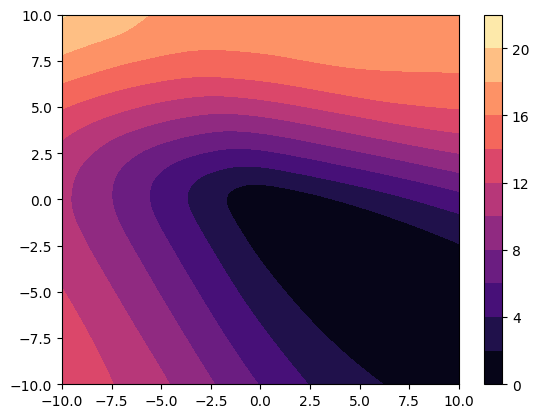

In [28]:
plt.contourf(W11, W22, L, 10, cmap='magma')
plt.colorbar()

Vous voyez ci-dessus l'évolution de la fonction coût en fonction de W1 et W2.

Maintenant, reprenons les mêmes données qu'au début, mais en multipliant le vecteur X2 par 5.

In [29]:
X, y  = make_blobs(n_samples=100, n_features=2, centers=2, random_state=0)
X[:, 1] *= 5

y = y.reshape((y.shape[0], 1))

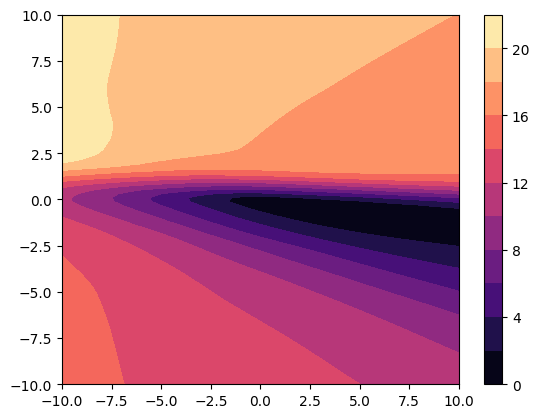

In [30]:
b = 0
Z = X.dot(W_final) + b
A = 1 / (1 + np.exp(-Z))

epsilon = 1e-15
L =  1 / len(y) * np.sum( -y * np.log(A + epsilon) - (1 - y) * np.log(1 - A + epsilon), axis=0).reshape(W11.shape)
L.shape

#graphique
plt.contourf(W11, W22, L, 10, cmap='magma')
plt.colorbar()

Ci dessus, toujours l'évolution de la fonction coût en fonction de W1 et W2.  
On voit ici qu'en effet, notre fonction coût a été fortement compressée.  
C'est pour cette raison que notre algorithme de descente de gradients va avoir du mal à converger et trouver le minimum.  
Il est donc nécessaire de normaliser tout cela.

## F. Résolution de l'erreur *d'overflow*

Créons notre fonction de normalisation pour nos pixels.  
Nos images sont codées en 8 bits, donc avec des pixels d'une valeur comprise entre 0 et 255.  
Nous allons ramener ces valeurs à une valeur entre 0 et 1.

In [31]:
# fonction inutilisée car moyen plus simple de faire
def get_value_to_normalize_with_bits(amountBits=8):
    valueBitsInDeci = 1
    for i in range(1,amountBits):
        valueBitsInDeci += 2**i
    
    return valueBitsInDeci

In [32]:
X_train_reshape = flatten_image(X_train) / X_train.max()    # max = 255 -> 255/255=1
X_test_reshape = flatten_image(X_test) / X_test.max()

Cela fait, réentrainons notre neurone.

taux de réussite :  0.518


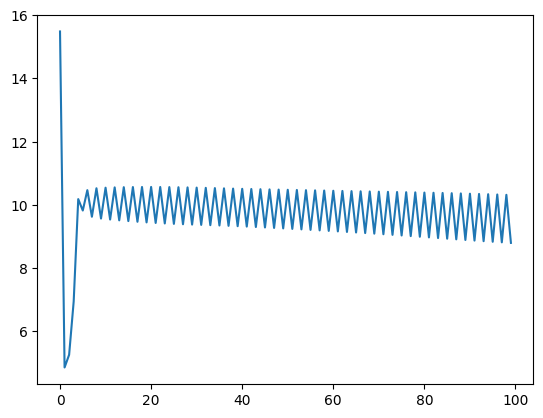

In [33]:
W, b = artificial_neuron(X_train_reshape, y_train)

L'erreur "d'overflow" a bel et bien disparue, mais notre neurone n'apprend toujours pas correctement...  
L'oscillement du neurone est probablement dû au "learning rate" (donc au pas d'apprentissage) trop gros.  
En effet, lors de notre descente de gradients, si notre pas est trop gros, l'algorithme fera juste des vas-et-viens, sans trouver la bonne valeur minimale.

## G. Performance du modèle

Affichons la performance du modèle, pour voir si ce dernier apprend bel est bien de manière satisfaisante.  
Pour cela, nous allons rajouter un graphique, représentant la performance du modèle.

In [34]:
#!pip install tqdm
from tqdm import tqdm

In [35]:
def artificial_neuron(X, y, learning_rate = 0.1, n_iter = 100):
    # initialisation W, b
    W, b = initialisation(X)
    
    Loss = []
    acc = []
    
    for i in tqdm(range(n_iter)):   #tqdm -> barre de progression
        # activations
        A = model(X, W, b)

        #pour éviter que ça soit trop lent
        if (i % 10 == 0):
            # calcul coût
            Loss.append(log_loss(A, y))

            # calcul accuracy
            y_pred = predict(X, W, b)
            acc.append(accuracy_score(y, y_pred))

        # mise à jour
        dW, db = gradients(A, X, y)
        W, b = update(dW, db, W, b, learning_rate)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(Loss)
    plt.subplot(1, 2, 2)
    plt.plot(acc)
    plt.show()
    
    return (W, b)

100%|██████████| 10000/10000 [00:06<00:00, 1618.43it/s]


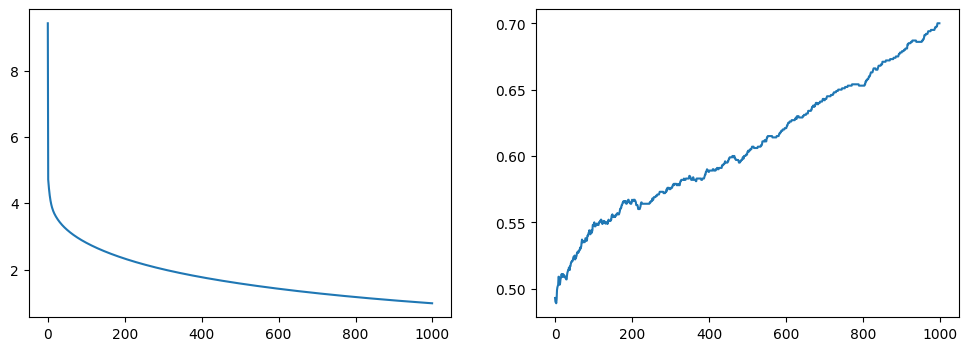

In [36]:
W, b = artificial_neuron(X_train_reshape, y_train, learning_rate=0.01, n_iter=10000)

On voit que le modèle apprend bel et bien, mais la performance reste mauvaise.
Le modèle fait de mauvaises prédictions sur le test set, c'est "l'overfitting".
On le remarque facilement quand la courbe de loss du train diminue mais que celle du test commence à stagner.
Pour l'accuracy, le train s'améliore, mais le test commence à stagner, voire se dégrader.

Nous allons donc re modifier le code de notre neurone afin de tracer notre courbe de test.

In [37]:
def artificial_neuron(X_train, y_train, X_test, y_test, learning_rate = 0.1, n_iter = 100):
    # initialisation W, b
    W, b = initialisation(X_train)
    
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    for i in tqdm(range(n_iter)):   #tqdm -> barre de progression
        # activations
        A = model(X_train, W, b)

        #pour éviter que ça soit trop lent
        if (i % 10 == 0):

            # Train
            train_loss.append(log_loss(A, y_train))
            y_pred = predict(X_train, W, b)
            train_acc.append(accuracy_score(y_train, y_pred))
            
            # Test
            A_test = model(X_test, W, b)
            test_loss.append(log_loss(A_test, y_test))
            y_pred = predict(X_test, W, b)
            test_acc.append(accuracy_score(y_test, y_pred))

        # mise à jour
        dW, db = gradients(A, X_train, y_train)
        W, b = update(dW, db, W, b, learning_rate)
    
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train acc')
    plt.plot(test_acc, label='test acc')
    plt.show()
    
    return (W, b)

100%|██████████| 10000/10000 [00:06<00:00, 1438.44it/s]


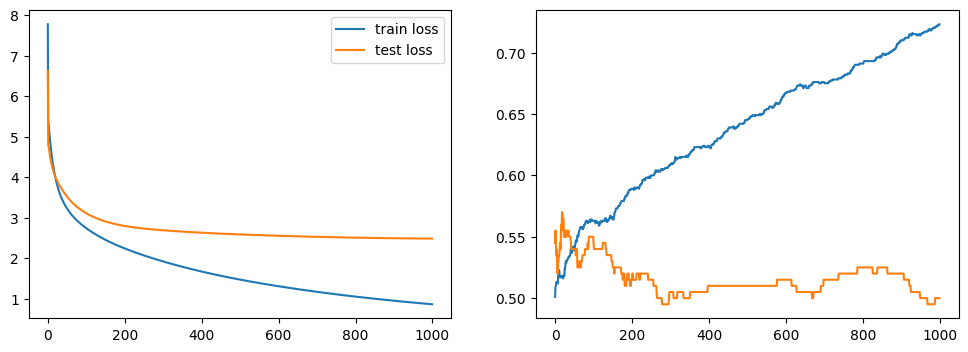

In [38]:
W, b = artificial_neuron(X_train_reshape, y_train, X_test_reshape, y_test, learning_rate=0.01, n_iter=10000)

L'overfitting est confirmé : le modèle fait beaucoup plus d'erreurs sur le test set que sur le train set.  
De même avec l'accuracy : le modèle a beau progresser sur le train set, il n'arrive pas à généraliser car il n'arrive pas du tout à s'en sortir avec le test set.  
  
Comment régler ce problème ?  
Peut-être en donnant plus de photos à notre IA, cela pourrait résoudre certains de nos problèmes :
- 1000 photos n'est pas assez pour entraîner correctement un modèle
- Fléaut de la dimension : décalage entre le nombre de photos et le nombre de variables
  &nbsp;  
  &nbsp;  

Malheureusement, la réalité est tout autre...  
Le problème vient en fait du modèle lui-même. En effet, ce dernier est trop simpliste, il a un fonctionnement linéaire, ne lui permettant pas de gérer ce genre de problème (je parle ici de comparer des images).  

Mais alors, comment améliorer notre modèle ?  
En lui rajoutant des neurones !  

Nous allons créer notre premier réseau de neurones artificiels.  
Cela bien sûr, dans le prochain NoteBook.